In [51]:
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame

from caveat.evaluate.describe.frequency import frequency_plots
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot

In [52]:
cmap = {
    "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    "other": (1.0, 1.0, 0.7019607843137254),
    "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    "education": (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
    "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
}

batch_root = Path("../logs/sequence_models/cnn_w")
xs = ["uu", "iu", "ui"]
ys = [""]
zs = [""]

batch_paths = {}
for x in xs:
    for y in ys:
        for z in zs:
            batch_paths[f"{x}{y}{z}"] = batch_root / f"{x}{y}{z}"


# find data
target_schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
acts = list(target_schedules.act.value_counts(ascending=False).index)
class_map = {n: i for i, n in enumerate(acts)}

target_attributes = pd.read_csv("../tmp/nts_home_attributes_groups.csv")


def latest(path: Path):
    versions = sorted(
        [
            d
            for d in path.iterdir()
            if d.is_dir() and d.name.startswith("version")
        ]
    )
    return path.name, versions[-1]


def iter_models(path: Path):
    for dir in path.iterdir():

        if dir.is_dir():

            yield latest(dir)


def find_nth(path: Path, n=0):

    ranks = (
        pd.read_csv(path / "domain_distances.csv")
        .drop(columns=["domain", "observed", "mean", "std"], errors="ignore")
        .rank(axis=1, method="min")
        .sum(axis=0)
    )
    ranked = [i for _, i in sorted(zip(ranks, ranks.index))]
    top = ranked[n]
    dir = path / top
    yield latest(dir)


def load_attributes(path: Path, default=None):
    if (path / "synthetic_attributes.csv").exists():
        print(f"Loading synthetic attributes from {path}")
        return pd.read_csv(path / "synthetic_attributes.csv")
    if (path / "synthetic_labels.csv").exists():
        print(f"Loading synthetic labels from {path}")
        return pd.read_csv(path / "synthetic_labels.csv")
    print(f"Failed to find attributes at {path}")
    return default


def load_zs(path: Path, default=None):
    if (path / "synthetic_zs.csv").exists():
        print(f"Loading zs from {path}")
        return pd.read_csv(path / "synthetic_zs.csv", header=None)
    print(f"Failed to find zs at {path}")
    return default


def plot_zs(zs, figsize=(10, 6), cmap=None, sample=0.1):
    if not cmap:
        cmap = {
            "employed": "royalblue",
            "unemployed": "gray",
            "student": "salmon",
        }
    fig, axs = plt.subplots(1, len(zs), figsize=figsize)
    if len(zs) > 1:
        axs = axs.flatten()
    else:
        axs = [axs]
    for ax, (name, data) in zip(axs, zs.items()):

        sample_data = data.sample(frac=sample)
        colors = None

        ax.set_title(name)
        ax.scatter(
            sample_data.loc[:, 0], sample_data.loc[:, 1], alpha=1, s=5, c=colors
        )
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
    return fig

In [53]:
schedules = {
    n: pd.read_csv(latest(p)[1] / "synthetic_schedules.csv")
    for n, p in batch_paths.items()
}
zs = {n: load_zs(latest(p)[1], default=None) for n, p in batch_paths.items()}

Loading zs from ../logs/sequence_models/cnn_w/uu/version_0
Loading zs from ../logs/sequence_models/cnn_w/iu/version_0
Loading zs from ../logs/sequence_models/cnn_w/ui/version_0


In [54]:
test_zs = {
    n: pd.read_csv(latest(p)[1] / "test_inference" / "zs.csv", header=None)
    for n, p in batch_paths.items()
}

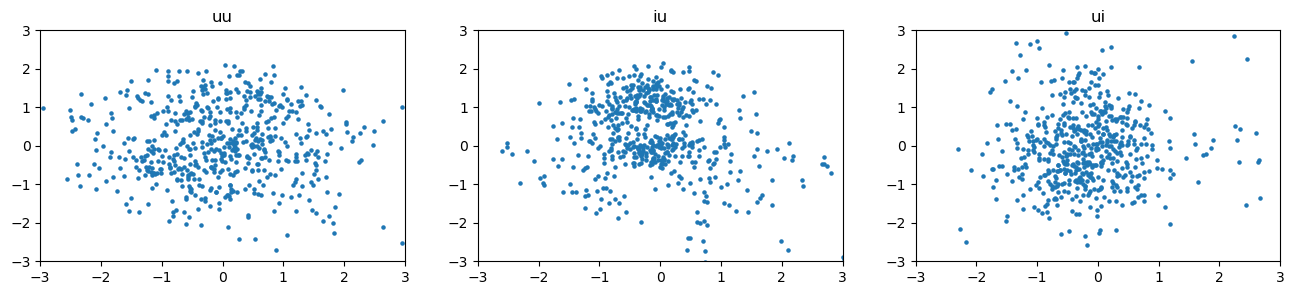

In [55]:
fig = plot_zs(test_zs, sample=0.1, figsize=(16, 3))

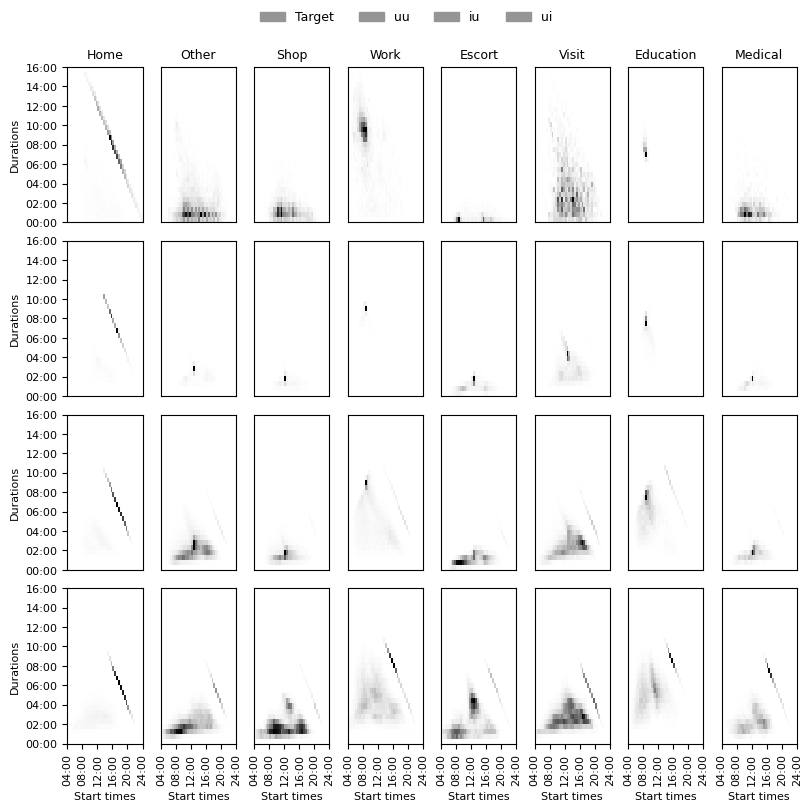

In [56]:
fig = joint_time_distributions_plot(
    target_schedules,
    schedules,
    figsize=(8, 8),
    observed_title="Target",
    # cmaps={
    #     0: "Greys",
    #     1: "Oranges",
    #     2: "Greens",
    #     3: "Reds",
    #     4: "Purples",
    #     5: "Blues",
    #     6: "YlOrBr",
    #     7: "YlGnBu",
    #     8: "RdPu",
    #     9: "Blues",
    # },
    cmaps={
        0: "Greys",
        1: "Greys",
        2: "Greys",
        3: "Greys",
        4: "Greys",
        5: "Greys",
        6: "Greys",
        7: "Greys",
        8: "Greys",
        9: "Greys",
    },
)

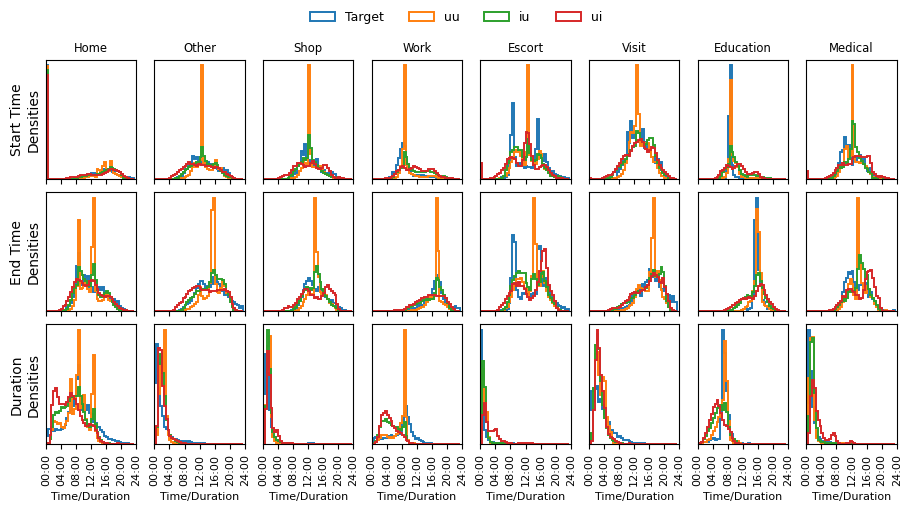

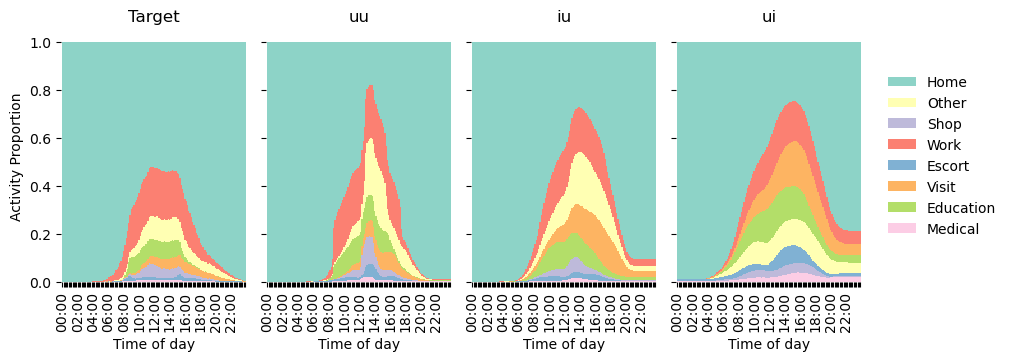

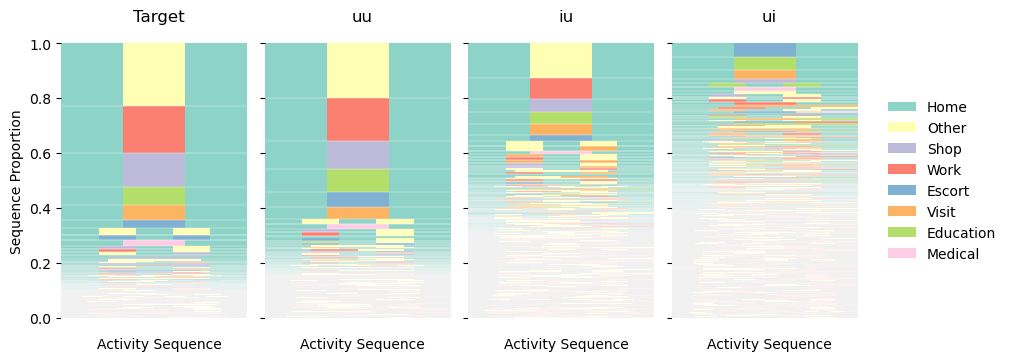

In [57]:
fig = times_distributions_plot(
    target_schedules, schedules, observed_title="Target", figsize=(9, 5)
)
fig = frequency_plots(
    target_schedules,
    schedules,
    color=cmap,
    figsize=(10, 3.5),
    observed_title="Target",
)
fig = sequence_prob_plot(
    target_schedules,
    schedules,
    cmap=cmap,
    figsize=(10, 3.5),
    observed_title="Target",
)

In [58]:
import random

from pam.core import Household, Person
from pam.plot.plans import plot_household

from caveat.data.utils import trace_to_pam


def stretch(schedules):
    return schedules.groupby(schedules.pid).apply(stretcher)


def stretcher(schedule):
    duration = schedule.duration.sum()
    if duration != 1440:
        a = 1440 / duration
        schedule.duration = (schedule.duration * a).astype(int)
        accumulated = list(schedule.duration.cumsum())
        schedule.start = [0] + accumulated[:-1]
        schedule.end = accumulated
    return schedule


def trim(schedules):
    schedules[schedules.end > 1440] = 1440
    schedules[schedules.start > 1440] = 1440
    schedules.duration = schedules.end - schedules.start
    schedules = schedules[schedules.duration > 0]
    return schedules


def pad(schedules):
    return (
        schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
    )


def padder(schedule):
    if schedule.end.iloc[-1] < 1440 and schedule.act.iloc[-1] != "home":
        pid = schedule.pid.iloc[0]
        schedule = pd.concat(
            [
                schedule,
                DataFrame(
                    {
                        "pid": pid,
                        "start": schedule.end.iloc[-1],
                        "end": 1440,
                        "duration": 1440 - schedule.end.iloc[-1],
                        "act": "home",
                    },
                    index=[0],
                ),
            ]
        )
    elif schedule.end.iloc[-1] < 1440:
        schedule.end.iloc[-1] = 1440
        schedule.duration.iloc[-1] = 1440 - schedule.start.iloc[-1]
    return schedule


def plot_schedules(schedules, **kwargs):

    cmap = {
        "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
        "other": (1.0, 1.0, 0.7019607843137254),
        "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
        "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
        "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
        "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
        "education": (
            0.7019607843137254,
            0.8705882352941177,
            0.4117647058823529,
        ),
        "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
        "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    }
    cmap = {n.title(): c for n, c in cmap.items()}

    hh = Household("")

    pids = schedules.pid
    selected = random.sample(list(pids), 5)
    for i, pid in enumerate(selected):
        person = Person(pid)
        plan = schedules[schedules.pid == pid]
        plan = trim(stretch(pad(plan)))[["act", "start", "end", "duration"]]
        mapping = {a: a for a in plan.act}

        trace = [
            (row.act, row.start, row.end, row.duration)
            for i, row in plan.iterrows()
        ]
        plan = trace_to_pam(trace, mapping)

        person = Person(i)
        person.plan = plan
        hh.add(person)

    plot_household(hh, cmap=cmap, width=25)

/tmp/ipykernel_881136/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_881136/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_881136/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

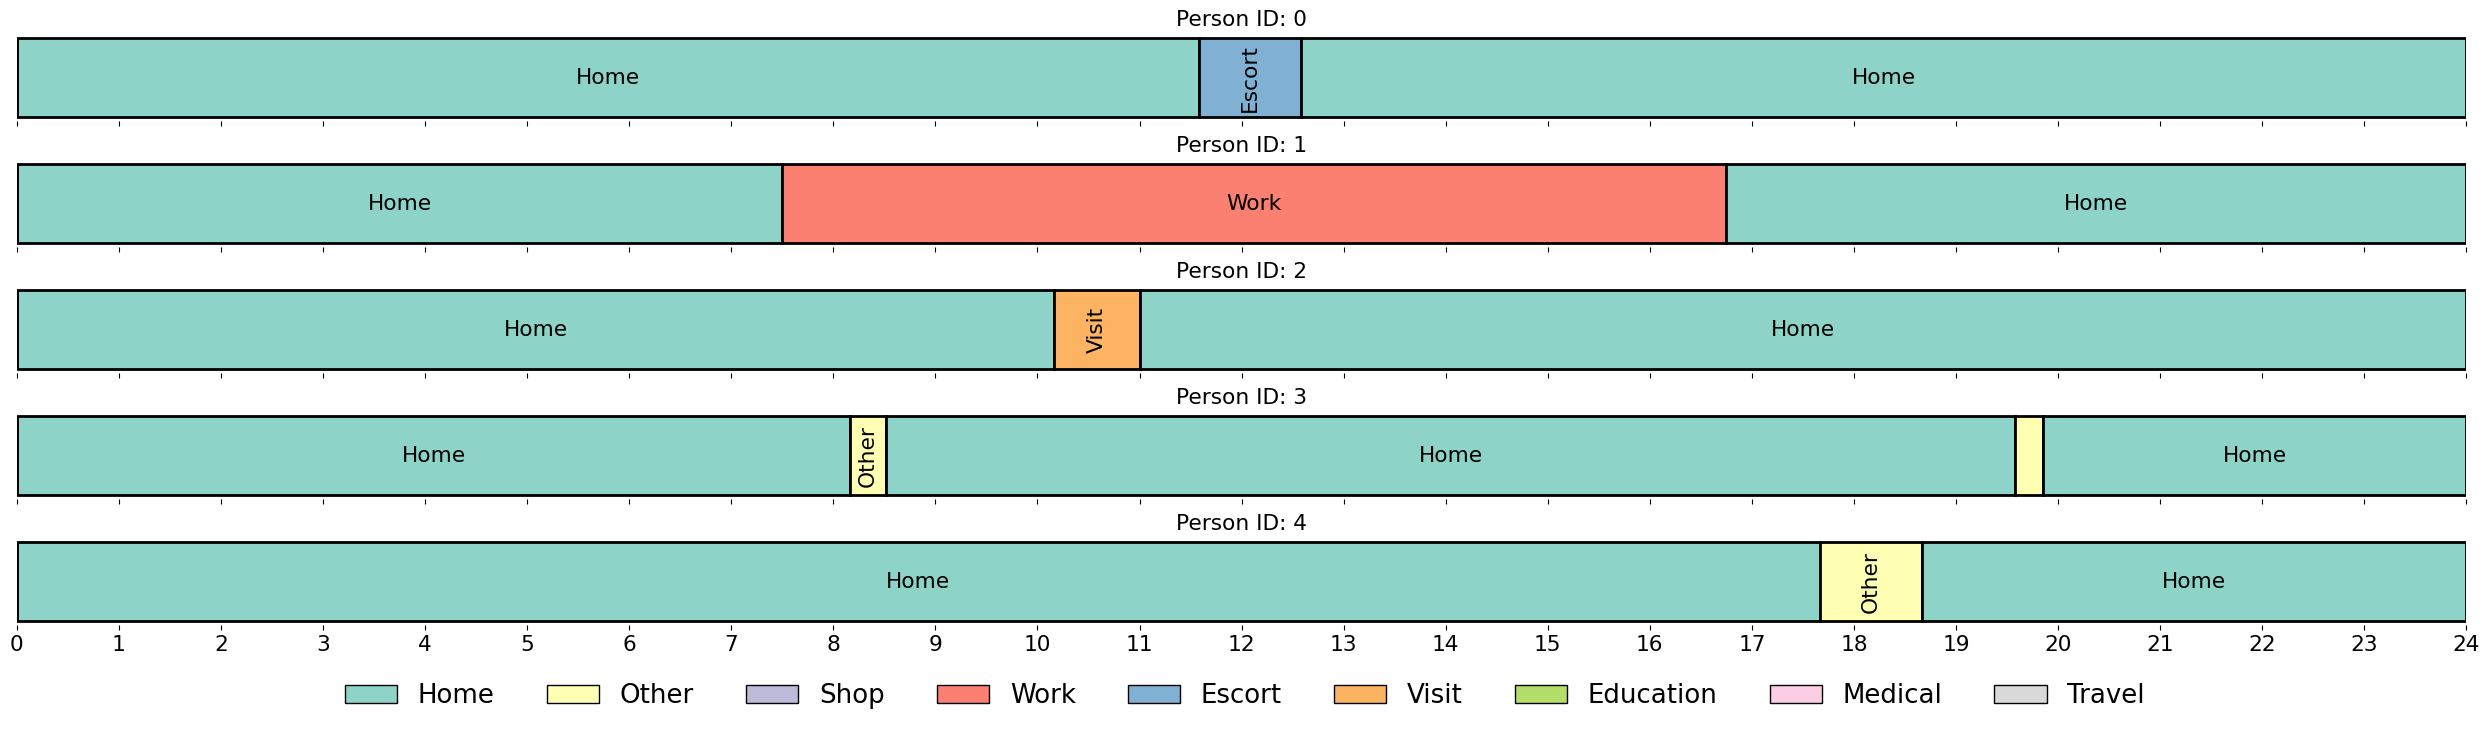

In [59]:
plot_schedules(target_schedules)

/tmp/ipykernel_881136/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_881136/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_881136/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

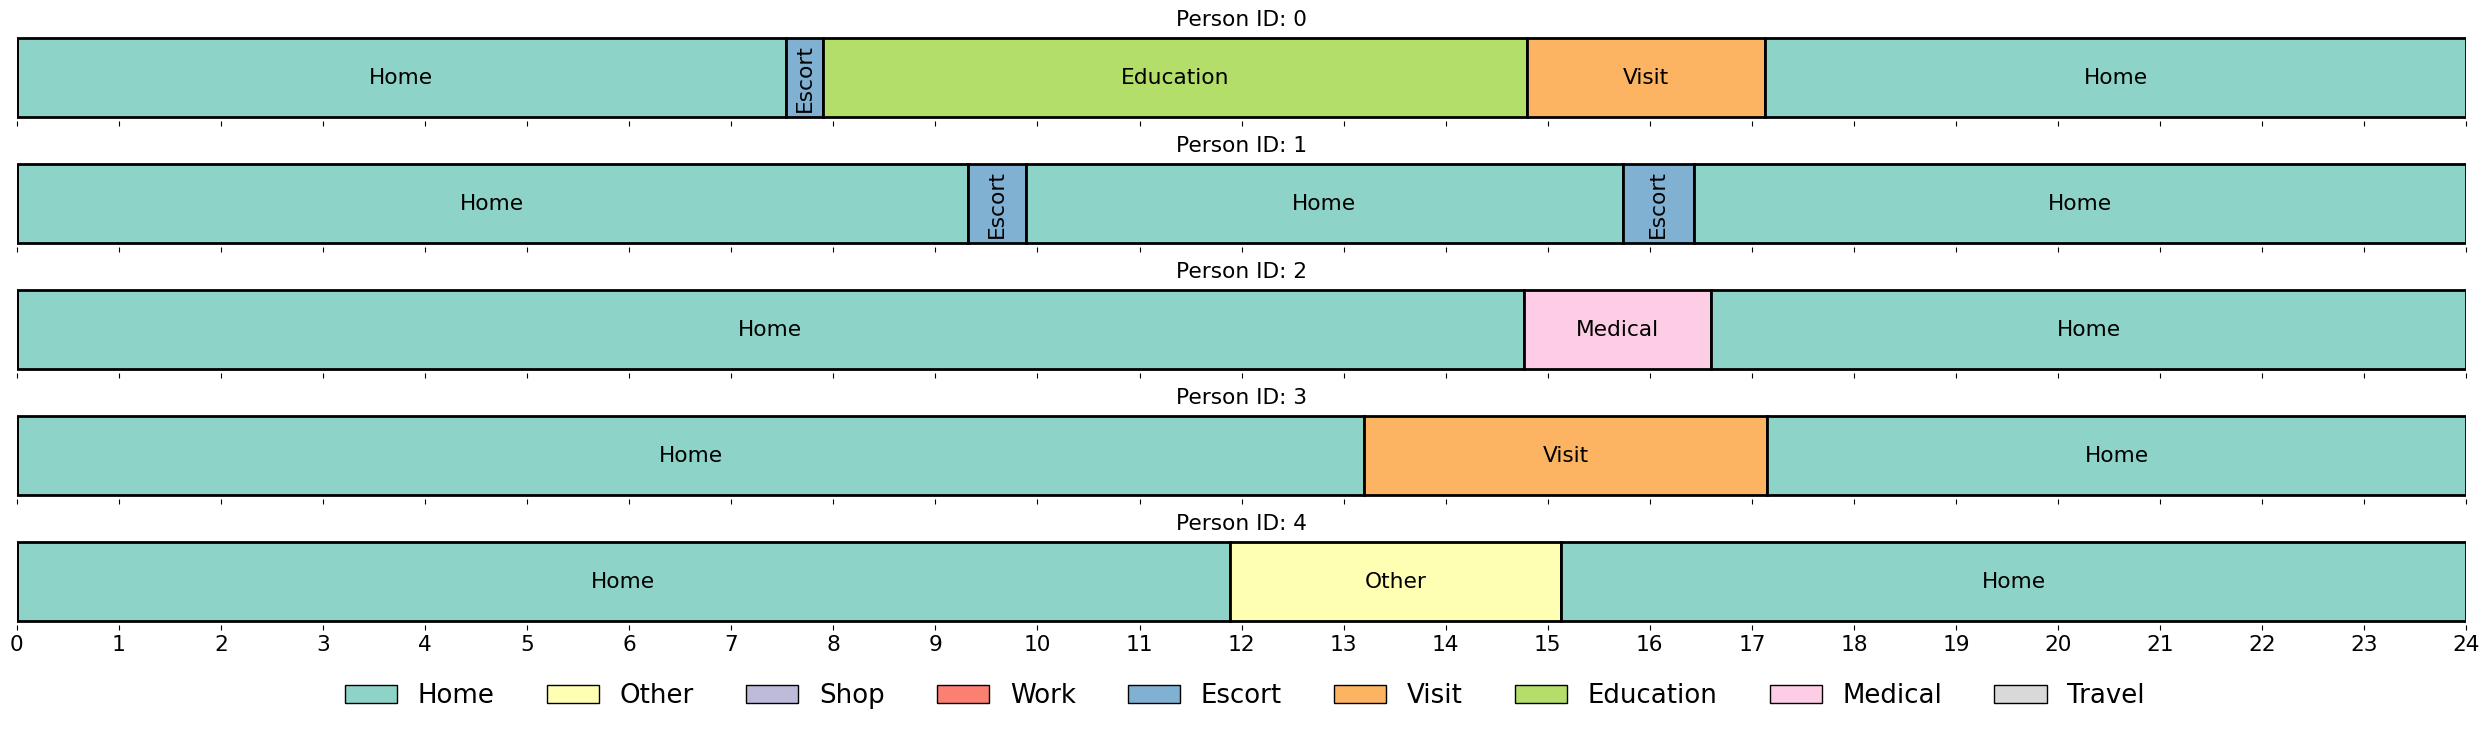

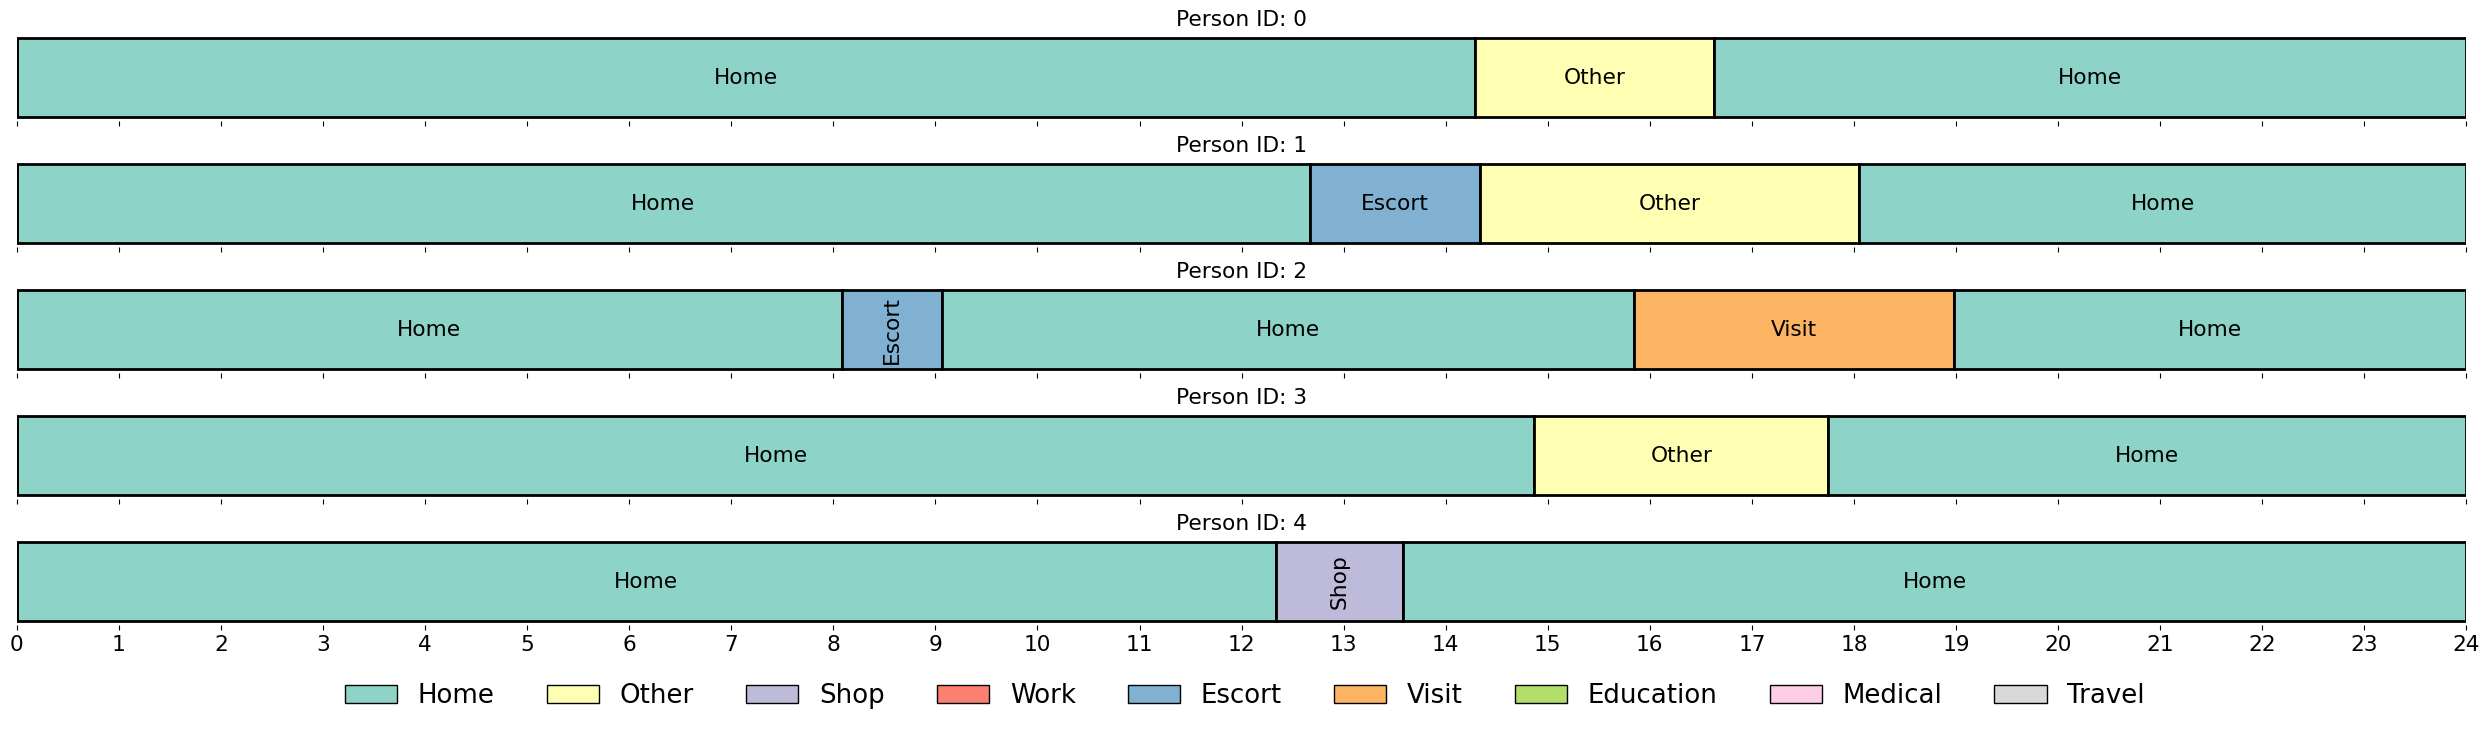

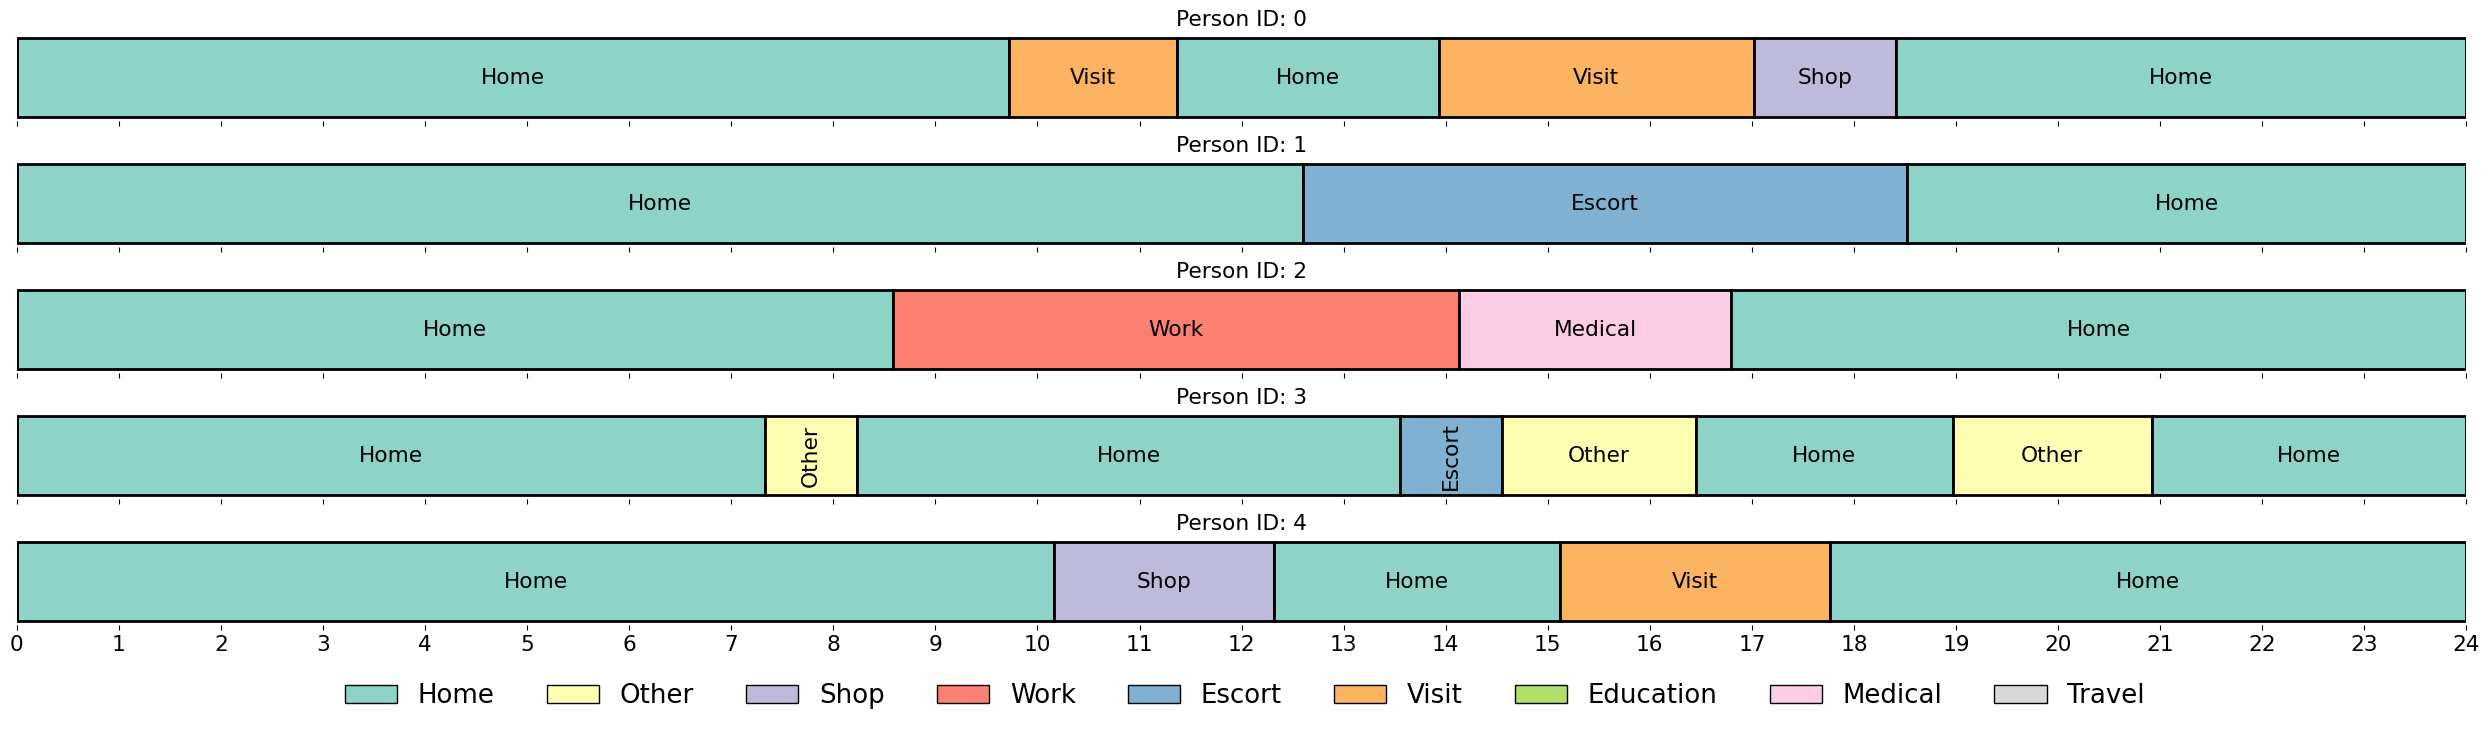

In [60]:
for n, p in batch_paths.items():
    examples = pd.read_csv(latest(p)[1] / "synthetic_schedules.csv")
    plot_schedules(examples)

In [61]:
def build_distance_tables(batch_paths, suffix=""):
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():
        distances = pd.read_csv(
            path / f"domain_distances{suffix}.csv"
        ).set_index("domain")

        columns = list(
            set(distances.columns) - set(["domain", "observed", "mean", "std"])
        )
        distances_combined[(name, "EMD")] = distances[columns].mean(axis=1)
        distances_combined[(name, "var")] = distances[columns].var(axis=1)

    distances_combined.columns = pd.MultiIndex.from_tuples(
        distances_combined.columns
    )

    # distances_combined = distances_combined.set_index(
    #     pd.MultiIndex.from_tuples(distances_combined.index)
    # )

    return distances_combined


df = build_distance_tables(batch_paths, suffix="")
print(df[::-1].to_latex(float_format="{:.3f}".format))
df

FileNotFoundError: [Errno 2] No such file or directory: '../logs/sequence_models/cnn_w/uu/domain_distances.csv'

In [ ]:
df = build_distance_tables(batch_paths, suffix="_subs")
print(df[::-1].to_latex(float_format="{:.3f}".format))
df

In [ ]:
def build_feature_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "feature_descriptions.csv").set_index(
            ["domain", "feature"]
        )
        distances = pd.read_csv(path / "feature_distances.csv").set_index(
            ["domain", "feature"]
        )
        print(distances.columns)

        columns = set(descriptions.columns)
        columns = list(
            columns - set(["observed", "description", "mean", "std"])
        )
        assert len(columns) == 5

        descriptions_combined[(name, "mean")] = descriptions[columns].mean(
            axis=1
        )
        # descriptions_combined[(name, "var")] = descriptions[columns].var(axis=1)
        descriptions_combined[(name, "EMD")] = distances[columns].mean(axis=1)

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    descriptions_combined[("Observed", "")] = descriptions["observed"]
    descriptions_combined[("Description", "")] = descriptions["description"]

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order = [("Observed", "")] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_feature_description_tables(batch_paths)
table

In [ ]:
for n in ["aggregate", "participations", "transitions", "timing"]:
    print(n)
    print(table.loc[n].to_latex(float_format="{:.3f}".format))
    print()

In [ ]:
def build_creativity_table(batch_paths):
    descriptions_combined = pd.DataFrame()
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = (
            pd.read_csv(path / "descriptions.csv")
            .set_index(["domain", "feature", "segment"])
            .loc["creativity"]
        )
        distances = (
            pd.read_csv(path / "distances.csv")
            .set_index(["domain", "feature", "segment"])
            .loc["creativity"]
        )

        columns = set(descriptions.columns)
        weights = set([c for c in columns if "weight" in c])
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
            - weights
        )

        descriptions_combined[name, "desc."] = descriptions[columns].mean(
            axis=1
        )

        distances_combined[name, "dist."] = distances[columns].mean(axis=1)

    descriptions_combined["Observed", ""] = descriptions["observed"]
    descriptions_combined["Description", ""] = descriptions["description"]

    print(descriptions_combined.columns)

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    distances_combined["Observed", ""] = distances["observed"]
    distances_combined["Description", ""] = distances["distance"]

    distances_combined.columns = pd.MultiIndex.from_tuples(
        distances_combined.columns
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order.pop(order.index(("Description", "")))
    order = [("Observed", "")] + order + [("Description", "")]
    descriptions_combined = descriptions_combined.loc[:, order]

    order = list(distances_combined.columns)
    order.pop(order.index(("Observed", "")))
    order.pop(order.index(("Description", "")))
    order = [("Observed", "")] + order + [("Description", "")]
    distances_combined = distances_combined.loc[:, order]

    return pd.concat((descriptions_combined, distances_combined), axis=0)


table = build_creativity_table(batch_paths)
table

In [ ]:
def build_all_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions.csv").set_index(
            ["domain", "feature", "segment"]
        )
        distances = pd.read_csv(path / "distances.csv").set_index(
            ["domain", "feature", "segment"]
        )

        columns = set(descriptions.columns)
        weights = set([c for c in columns if "weight" in c])
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
            - weights
        )

        descriptions_combined[name, "mean"] = descriptions[columns].mean(axis=1)
        # descriptions_combined[name, "var"] = descriptions[columns].var(axis=1)
        descriptions_combined[name, "EMD"] = distances[columns].mean(axis=1)

    descriptions_combined["weight", ""] = distances["observed__weight"]
    descriptions_combined["Observed", ""] = descriptions["observed"]
    descriptions_combined["Description", ""] = descriptions["description"]

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    descriptions_combined = descriptions_combined.groupby(
        ["domain", "feature"], group_keys=False
    ).apply(
        lambda x: x.sort_values(
            [("weight", ""), ("Observed", "")], ascending=False
        ).head(20)
    )
    descriptions_combined = descriptions_combined.drop(("weight", ""), axis=1)

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order = [("Observed", "")] + order

    index = [
        "aggregate",
        "participations",
        "transitions",
        "timing",
        "sample quality",
        "creativity",
    ]

    return descriptions_combined.loc[index, order]


table = build_all_description_tables(batch_paths)

In [ ]:
print(table.loc["sample quality"].to_latex(float_format="{:.3f}".format))
table.loc["sample quality"]

In [ ]:
table.loc["creativity"]

In [ ]:
p = table.loc["participations"]
for name in ["lengths", "participation rate", "pair participation rate"]:
    print(name)
    print(p.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["participations"]

In [ ]:
t = table.loc["transitions"]
for name in ["2-gram", "3-gram"]:
    print(name)
    print(t.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["transitions"]

In [ ]:
t = table.loc["timing"]
for name in ["durations", "start times", "end times", "start-durations"]:
    print(name)
    print(t.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["timing"]

In [ ]:
print(table.to_latex(float_format="{:.3f}".format))

In [ ]:
for domain in [
    "creativity",
    "sample quality",
    "aggregate",
    "participations",
    "transitions",
    "timing",
]:
    print()
    print(domain)
    print()
    ss = table.loc[domain]
    for feature in set(ss.reset_index()["feature"]):
        print(feature)
        print()
        print(ss.loc[feature].to_latex(float_format="{:.3f}".format))

In [ ]:
def build_subs_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions_subs.csv").set_index(
            ["domain", "feature", "segment", "sub_pop"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    descriptions_combined = (
        descriptions_combined.sort_values("Observed", ascending=False)
        .groupby(["domain", "feature", "sub_pop"])
        .head(100)
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_subs_description_tables(batch_paths)
table

In [ ]:
table.loc[
    "participations",
    "participation rate",
    "work0",
    ["work_status=student", "work_status=employed"],
]

In [ ]:
table.loc[
    "participations",
    "participation rate",
    "education0",
    ["work_status=student", "work_status=employed"],
]